In [23]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Логистическая регрессия

В логистической регрессии мы предсказываем вероятность появления одного из событий. Предположим, у нас бинарное событие. Например, если бы книги оценивались просто как "хорошие", "плохие", то мы бы пытались предсказать вероятность, с какой книгам ставят оценку "хорошая", "плохая". Но искать вероятность можно не только для бинарных событий. Это могут быть и непрерывные величины. В наших реальных данных оценка книги ставится не как "хорошая", "плохая", а как 3 или 4, а предсказываем мы среднее значение, которое может быть 3,9.

Сразу оговорим условия применения модели:

1) категориальные переменные должны быть закодированы;
2) непрерывные переменные должны быть масштабированы и приведены к нормальному распределению;
3) независимость переменных;
4) наличие линейной зависимости между хотя бы одной перtменной и логитом зависимой переменной;
5) отсутствие мультиколлинеарности между переменными;
6) отсутствие дисбаланса классов.

Теперь посмотрим, как же решается задача логистической регрессии.

Вспомним, что в линейной регрессии исходят из того, что зависимую переменную может дать формула:

$$ f(X) = \beta_0 + \beta_1 X_1$$

В логистической регрессии ищут не само Y, а вероятность Y, что можно записать так:

$$ E(Y|x) = \beta_0 + \beta_1 x $$

Мы видим, что слева стоит E(Y|x), которое, раз это вероятность, может принять значение только между 0 и 1. Справа же стоит выражение, которое может оказаться любым, а значит за границами отрезка от 0 до 1. Значит, если мы хотим найти, какие коэффициент справа дают наибольшую вероятность получить искомый Y, надо надо что-то изменить. Менять формулу справа смысла нет, ведь она "работает" с переменными, подгоняет их. Нам надо изменить формулу слева, то есть заставить вероятность "работать" не в границах между 0 и 1, а в границах от минус бесконечности до плюс бесконечности. Вот как этого добиваются. Для начала превратим вероятность в шансы (odds). Для этого нужно поделить вероятность желаемого события (P) на вероятность обратного желаемому событию (1–P). 

$$Odds = \frac{P}{1-P} \in [0, +\infty)$$

Однако это даст результаты только в границах от нуля до плюс бесконечности, а нам нужно от минус бесконечности до плюс бесконечности. Этого можно добиться, если перевести нашу формулу в логарифмическую форму.

$$\ln(Odds) = \ln\left(\frac{P}{1-P}\right) \in (-\infty, +\infty)$$

Тогда у нас вероятность определяется на минус бесконечности – плюс бесконечности, как и формула линейной регрессии:

$$\ln\left(\frac{P}{1-P}\right) = \beta_0 + \beta_1 x$$

Особенность этого уравнения в том, что его права часть дает линейную зависимость, а вот левая - нелинейную. Но теперь мы все-таки хотим получить вероятность, то есть P. Для этого нужно избавиться от логарифма слева. У нас слева натуральный логарифм, значит можно записать в равнозначной форме:

$$e^{\ln\left(\frac{P}{1-P}\right)} = e^{\beta_0 + \beta_1 x}$$

Слева экспонента и логарифм "погашают" друг друга:

$$\frac{P}{1-P} = e^{\beta_0 + \beta_1 x}$$

Дальше выполняем такие преобразования:

$$P = e^{\beta_0 + \beta_1 x} (1 - P)$$

$$P = e^{\beta_0 + \beta_1 x} - P \cdot e^{\beta_0 + \beta_1 x}$$

Делаем перенос, выносим общий множитель:

$$P (1 + e^{\beta_0 + \beta_1 x}) = e^{\beta_0 + \beta_1 x}$$

Как результат:

$$P(Y=1|x) = \frac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}} = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}}$$

Это называется логит-трансформацией. Логит позволяет сохранить важные свойства линейной регрессии: является линейным по параметрам, может принимать значения x от минус до плюс бесконечности. Теперь мы знаем, как перевести признаки в вероятность события. Нам нужно настроить коэффициенты справа таким образом, чтобы вероятность получить зависимую переменную была максимальной. Это делается с помощью метода наибольшего правдоподобия. 

Для начала нам надо перейти с $P(Y=1|x)$ к $P(y_i|x_i)$. Разница в том, что $P(Y=1|x)$ показывает вероятность получить значение 1, то есть желаемое нами. А вот $P(y_i|x_i)$ показывает вероятность получить либо 1, либо 0, то есть желаемое или нежелаемое событие. Так как в нашей реальной таблице может быть как 1, так и 0, нам это нужно как-то записать. Делают это так:

$$P(y_i|x_i) = p_i^{y_i} \cdot (1 - p_i)^{1 - y_i}$$

Если $y_i = 1$, формула превращается в $p_i^1 \cdot (1-p_i)^0 = p_i$.

Если $y_i = 0$, формула превращается в $p_i^0 \cdot (1-p_i)^1 = 1 - p_i$.

Эту формулу мы должны применить к каждой строке нашей таблицы:

$$L(\beta) = \prod_{i=1}^{N} p_i^{y_i} (1 - p_i)^{1 - y_i}$$

Где $p_i = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}}$.

Максимизировать легче логарифм, поэтому формулу надо переписать в логарифмической форме, вот как это сделать.

Сначала запишем так:

$$L(\beta) = \prod_{i=1}^{N} \underbrace{p_i^{y_i} (1 - p_i)^{1 - y_i}}_{P(y_i|x_i)}$$

Берем натуральный логарифм слева и справа:

$$LL(\beta) = \ln(L(\beta)) = \ln\left( \prod_{i=1}^{N} p_i^{y_i} (1 - p_i)^{1 - y_i} \right)$$

Используем свойство: $\ln(a \cdot b \cdot c) = \ln(a) + \ln(b) + \ln(c)$.
Оператор произведения $\prod$ превращается в оператор суммирования $\sum$.

$$LL(\beta) = \sum_{i=1}^{N} \ln\left( p_i^{y_i} \cdot (1 - p_i)^{1 - y_i} \right)$$

Внутри скобки $\ln(\dots)$ у нас все еще произведение двух множителей: $A = p_i^{y_i}$ и $B = (1 - p_i)^{1 - y_i}$.
Снова применяем правило $\ln(A \cdot B) = \ln(A) + \ln(B)$:

$$LL(\beta) = \sum_{i=1}^{N} \left[ \ln(p_i^{y_i}) + \ln((1 - p_i)^{1 - y_i}) \right]$$

Используем свойство: $\ln(a^b) = b \cdot \ln(a)$.
Показатели степени ($y_i$ и $1-y_i$) «спускаются» вниз и становятся множителями перед логарифмом.

$$LL(\beta) = \sum_{i=1}^{N} [y_i \cdot \ln(p_i) + (1 - y_i) \cdot \ln(1 - p_i)]$$

Именно это уравнение и надо максимизировать. Для этого нам нужно взять производную функции. Наша функция $LL(\beta)$ зависит от вероятности p, но вероятность p зависит от беты. Значит, учитывая, что производная от суммы функций равна сумме их производных, производную будем искать так:

$$\frac{\partial LL}{\partial \beta} = \sum_{i=1}^{N} \left( \frac{\partial LL}{\partial p_i} \cdot \frac{\partial p_i}{\partial \beta} \right)$$

Вернемся сюда:

$$P(Y=1|x) = \frac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}} = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}}$$

Запишем это через $$z_i = \beta_0 + \beta_1 x_i$$ так:

$$p_i = \sigma(z_i) = \frac{1}{1 + e^{-z_i}}$$

Мы получаем, что $p(z(\beta))$ сложная функция. Вернемся к $$\frac{\partial p_i}{\partial \beta}$$, которое как сложная функция даст $$\frac{\partial p_i}{\partial \beta} = \frac{\partial p_i}{\partial z_i} \cdot \frac{\partial z_i}{\partial \beta}$$

Итак, у нас было: 

$$\frac{\partial LL}{\partial \beta} = \sum \left( \frac{\partial LL}{\partial p_i} \cdot \mathbf{\frac{\partial p_i}{\partial \beta}} \right)$$

А теперь, после подстановки, стало так:

$$\frac{\partial LL}{\partial \beta} = \sum \left( \frac{\partial LL}{\partial p_i} \cdot \underbrace{\left[ \frac{\partial p_i}{\partial z_i} \cdot \frac{\partial z_i}{\partial \beta} \right]}_{\text{раскрыли } \frac{\partial p_i}{\partial \beta}} \right)$$

Или для одного наблюдения:

$$\frac{\partial LL_i}{\partial \beta} = \underbrace{\frac{\partial LL_i}{\partial p_i}}_{\text{Шаг 1}} \cdot \underbrace{\frac{\partial p_i}{\partial z_i}}_{\text{Шаг 2}} \cdot \underbrace{\frac{\partial z_i}{\partial \beta}}_{\text{Шаг 3}}$$

Теперь будем выполнять операции по шагам. Начинаем с шага 1. Для одного наблюдения формула вероятности была такой:

$$LL_i = y_i \ln(p_i) + (1 - y_i) \ln(1 - p_i)$$

Дифференцируем по $p_i$. Здесь $y_i$ — константа.

1. Первое слагаемое: Производная $\ln(p_i)$ есть $\frac{1}{p_i}$.

$$\frac{\partial}{\partial p_i} [y_i \ln(p_i)] = \frac{y_i}{p_i}$$

2. Второе слагаемое: Производная сложной функции $\ln(1 - p_i)$.
Производная внешняя ($\ln(\cdot)$) умножить на производную внутреннюю ($1-p_i$).

$$\frac{\partial}{\partial p_i} [(1 - y_i) \ln(1 - p_i)] = (1 - y_i) \cdot \frac{1}{1 - p_i} \cdot \underbrace{(-1)}_{\text{производная от } -p_i}$$ $$= - \frac{1 - y_i}{1 - p_i}$$

3. Суммируем и приводим к общему знаменателю:

    $$\frac{\partial LL_i}{\partial p_i} = \frac{y_i}{p_i} - \frac{1 - y_i}{1 - p_i}$$

    Общий знаменатель: $p_i(1 - p_i)$.

    $$= \frac{y_i(1 - p_i) - p_i(1 - y_i)}{p_i(1 - p_i)}$$

    Раскрываем скобки в числителе:

    $$= \frac{y_i - y_i p_i - p_i + y_i p_i}{p_i(1 - p_i)}$$

    Слагаемые $-y_i p_i$ и $+y_i p_i$ сокращаются.
    Результат Шага 1:

    $$\frac{y_i - p_i}{p_i(1 - p_i)}$$

Шаг 2. Производная сигмоиды по линейному аргументу ($\frac{\partial p_i}{\partial z_i}$)

Это ключевой момент. Нам нужно продифференцировать функцию:


$$p_i = \frac{1}{1 + e^{-z_i}} = (1 + e^{-z_i})^{-1}$$

Используем правило дифференцирования степенной функции и сложной функции:

1. Берем производную внешней части (степени -1):

$$-(1 + e^{-z_i})^{-2}$$

2. Умножаем на производную внутренней части ($1 + e^{-z_i}$):
Производная $1$ равна $0$. Производная $e^{-z_i}$ равна $e^{-z_i} \cdot (-1)$.

$$-e^{-z_i}$$

3. Перемножаем:

$$\frac{\partial p_i}{\partial z_i} = \left( -(1 + e^{-z_i})^{-2} \right) \cdot \left( -e^{-z_i} \right) = \frac{e^{-z_i}}{(1 + e^{-z_i})^2}$$

4. Алгебраический трюк для упрощения: Разделим дробь на два множителя:

$$= \frac{1}{1 + e^{-z_i}} \cdot \frac{e^{-z_i}}{1 + e^{-z_i}}$$

Первый множитель — это само $p_i$.
Второй множитель можно представить как $\frac{(1 + e^{-z_i}) - 1}{1 + e^{-z_i}} = 1 - \frac{1}{1 + e^{-z_i}} = 1 - p_i$.

Результат Шага 2:$$p_i (1 - p_i)$$

Шаг 3. Производная линейной части по весам ($\frac{\partial z_i}{\partial \beta}$)

Здесь все линейно:

$$z_i = \beta_0 + \beta_1 x_i$$

Дифференцируем по конкретному коэффициенту $\beta$ (например, $\beta_1$):
Результат Шага 3: $$x_i$$

Теперь подставляем результаты всех трех шагов в исходную формулу цепного правила:

$$\frac{\partial LL_i}{\partial \beta} = \underbrace{\left[ \frac{y_i - p_i}{p_i(1 - p_i)} \right]}_{\text{Шаг 1}} \cdot \underbrace{\left[ p_i(1 - p_i) \right]}_{\text{Шаг 2}} \cdot \underbrace{\left[ x_i \right]}_{\text{Шаг 3}}$$

Знаменатель из первого шага $p_i(1 - p_i)$ и числитель из второго шага $p_i(1 - p_i)$ полностью сокращаются.

Итог для одного наблюдения:

$$(y_i - p_i) \cdot x_i$$

Итог для всей выборки (возвращаем сумму):

$$\frac{\partial LL}{\partial \beta} = \sum_{i=1}^{N} (y_i - p_i) x_i$$

Мы получили производную. В этом месте начинают использовать градиентный подъем, чтобы найти максимум функции.

Для этого нужно "подкручивать" беты и смотреть, куда двигается изменение нашей функции. Нам нужно, чтобы двигалось наверх. Вот как это можно записать:

$$\beta^{(t+1)} = \beta^{(t)} + \eta \cdot \frac{\partial LL}{\partial \beta}$$

Где:

$\beta^{(t)}$ — текущие значения коэффициентов;

$\eta$ (эта) — скорость обучения (learning rate). Маленькое число (например, 0.01), контролирующее длину шага, чтобы не «перепрыгнуть» через максимум;

$\frac{\partial LL}{\partial \beta}$ — тот самый градиент $\sum (y_i - p_i) x_i$, который мы только что вывели.

Эту формулу менее формально можно записать так:

$$\text{Наклон} = \sum (y_{факт} - p_{прогноз}) \cdot x$$

Если ошибка $(y-p)$ большая — наклон крутой, надо делать большой шаг.

Если ошибка почти ноль — мы почти на вершине (плато).

Чтобы применить эту формулу, мы берем любые случайные коэффициенты $\beta$ (например, нули). Это наша начальная точка на склоне. С помощью этих бет считаем p-прогноз, смотрим насколько ошиблись, а затем "подкручиваем" беты:

$$\beta_{новая} = \beta_{старая} + (\text{Скорость} \times \text{Наклон})$$

Мы делаем шаг, оказываемся в новой точке. Снова измеряем наклон. Снова делаем шаг. Мы повторяем это сотни или тысячи раз, пока наклон не станет равным нулю. Это значит, что мы на вершине.


Вернемся к нашим данным и посмотрим, как это работает.




In [3]:
db = pd.read_csv('gd_clean_data.csv', on_bad_lines='skip')
db = db.drop(['title', 'language_code', 'authors', 'editions_count', 'year', 'quarter'], axis=1)
db.info()
db.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10253 entries, 0 to 10252
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   average_rating      10253 non-null  float64
 1   num_pages           10253 non-null  int64  
 2   ratings_count       10253 non-null  int64  
 3   text_reviews_count  10253 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 320.5 KB


,average_rating,num_pages,ratings_count,text_reviews_count
0,3.59,501,4597666,94265
1,4.27,366,2530894,32871
2,3.80,277,2457092,43499


Для логистической регрессии нужен дихотамический признак. Надо превратить **average_rating** в такой признак. Однако здесь есть одна сложность, которая видна из описания данных. Половина средних оценок выше  3.96 и ниже 3.96. Только 25% оценок больше 4.14. Таким образом, если признать хорошими оценками только 4 и 5, то могут возникнуть сложности. Поэтому здесь можно снизить планку для оценки хорошо.

Итак, оценка хорошо - это будет оценка от 3.96. Плохая оценка будет ниже 3.96.

In [6]:
# Увеличиваем верхнюю границу > 5, чтобы включить 5.0 при полуоткрытом интервале
bins = [0, 3.96, 5.1] 

groups_names = ['0', '1'] 

# right=False меняет интервалы на [a, b)
# Класс 0: [0, 3.96) -> строго меньше 3.96
# Класс 1: [3.96, 5.1) -> больше или равно 3.96
db['rating_groups'] = pd.cut(db['average_rating'], bins, labels=groups_names, right=False).astype('int64')

db = db.drop('average_rating', axis=1)

Проверим, сколько наблюдений содержит каждый класс. Классы должны быть примерно одинаковыми по количеству. 

In [7]:
db['rating_groups'].value_counts(normalize=True)

rating_groups
1    0.507266
0    0.492734
Name: proportion, dtype: float64

Логистическую регрессию можно реализовать статистически, а можно через машинное обучение. Первое больше подходит для понимания, второе – для предсказаний. Начнем со статистического подхода. 

In [10]:
# вызываю и обучаю модель
model0 = smf.logit('rating_groups ~ num_pages + ratings_count + text_reviews_count', 
                    data=db).fit() 

# вызов результата модели
print(model0.summary()) 

Optimization terminated successfully.
         Current function value: 0.682300
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          rating_groups   No. Observations:                10253
Model:                          Logit   Df Residuals:                    10249
Method:                           MLE   Df Model:                            3
Date:                Thu, 25 Dec 2025   Pseudo R-squ.:                 0.01550
Time:                        12:23:04   Log-Likelihood:                -6995.6
converged:                       True   LL-Null:                       -7105.8
Covariance Type:            nonrobust   LLR p-value:                 1.749e-47
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4341      0.039    -11.267      0.000      -0.510      -0.359
num_p

Подобный вывод мы видели, когда разбирали линейную регрессию. Здесь у вертикали всего два этажа, их и посмотрим. Верхний этаж содержит служебную информацию слева, а справа - несколько полезных показателей. 

Возьмем Pseudo R-squ. Вот как считают этот показатель:

$$R^2_{McFadden} = 1 - \frac{\ln L_{full}}{\ln L_{null}}$$

Видим, что это показатель показывает, насколько лучше наша модель предсказывает, чем обычное среднее значение. У нас получилось значение 0.01550, что крайне низко. Модель логистической регрессии делает предсказание не лучше, чем обычное среднее.

На нижнем этаже мы видим коэффициенты при каждом признаке. Смотрим на P>|z|, если показатель не превышает 0.05, то принимаем результат. Мы видим, что только для num_pages коэффициент получен не случайно, то есть иметь связь с рейтингом. 

Перейдем к машинному обучению. 

Как и в случае с линейной регрессией, применение машинного обучения предполагает ответы на следующие вопросы:

1) Какую модель выбрать? Логистическая регрессия.

2) Как подготовить данные? Надо получить такие переменные, которые будут хорошо разделять зависимую переменную на 1 и 0. Для этого надо преобразовать имеющиеся переменные и получить новые. В рамках этого приведем количественные переменные к нормальному распределению и масштабируем данные. Категориальные данные закодируем. Как количественные, так и категориальные данные разобъем по группам.

3) Какие параметры модели настраивать и как? Будем использовать решетчатый поиск с кросс-валидацией.

4) Что будет оценкой качества модели? Точность, а также матрица ошибок.

5) Как можно получить предсказания по новым данным?

Порядок действий такой:

1) разделим данные на тренировочный и тестовый наборы;

2) обработаем переменные;

3) зададим модель логистической регрессии;

4) обучим модель с настройкой параметров и оценкой;

5) выберим лучшую модель;

6) применим для новых данных.

In [13]:
# 1. Формируем X и y
# Убедитесь, что в X остались только числовые признаки: num_pages, ratings_count, text_reviews_count
X = db.drop('rating_groups', axis=1) 
y = db['rating_groups']

# 2. Разбиение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Обучение через Pipeline
# Математическая необходимость: StandardScaler приводит каждый признак к mu=0 и sigma=1
# Это делает функционал ошибки J(beta) изотропным, ускоряя сходимость L-BFGS.
model = make_pipeline(
    StandardScaler(), 
    LogisticRegression(random_state=42, max_iter=1000)
)

model.fit(X_train, y_train)

# 4. Результаты
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.58      0.56      1516
           1       0.55      0.50      0.52      1560

    accuracy                           0.54      3076
   macro avg       0.54      0.54      0.54      3076
weighted avg       0.54      0.54      0.54      3076



Показатель accuracy дает только 54% угадываний. Вот как считается этот показатель:

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

Где:

$TP$ (True Positives): Истинно положительные (книги класса 1, угаданные как 1).

$TN$ (True Negatives): Истинно отрицательные (книги класса 0, угаданные как 0).

$FP$ (False Positives): Ложно положительные (ошибка I рода: класс 0 принят за 1).

$FN$ (False Negatives): Ложно отрицательные (ошибка II рода: класс 1 принят за 0).

В нашем случае общее количество объектов $N = 3076$. Модель угадала примерно $54\%$ из них, то есть $(TP + TN) \approx 1661$.

Эти результаты можно и визуализировать.

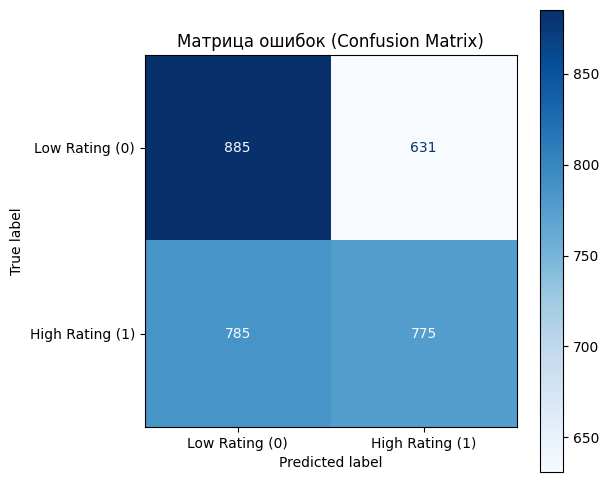

TN (True Negatives): 885
FP (False Positives): 631
FN (False Negatives): 785
TP (True Positives): 775


In [16]:
# 1. Вычисление матрицы (математическое ядро)
# y_test - истинные значения
# y_pred - предсказания модели
cm = confusion_matrix(y_test, y_pred)

# 2. Визуализация
# display_labels - подписи классов (0 и 1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Rating (0)', 'High Rating (1)'])

# Отрисовка
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d') # values_format='d' убирает научную нотацию (1e3)
plt.title("Матрица ошибок (Confusion Matrix)")
plt.show()

# 3. Числовой вывод для анализа
print("TN (True Negatives):", cm[0][0])
print("FP (False Positives):", cm[0][1])
print("FN (False Negatives):", cm[1][0])
print("TP (True Positives):", cm[1][1])

Перейдем к деревьям решений. Вот как можно представить их себе.

Изначально мы берем все признаки (столбцы, строки) и для каждого значения каждого признака делим всю таблицу на две части. Для каждой части считаем среднее значение. Например, мы разделим весь набор на две части, в одной среднее будет 5, в другой 10. Смотрим, насколько реальные значения нашего y совпадают с этими средними. Для каждой части получится свое значение. В итоге мы ищем такое разбиение, которое даст наименьшую разность.

Записать это можно так:

$$ R_1(j, s) = \{X \mid X_j < s\} \quad \text{и} \quad R_2(j, s) = \{X \mid X_j \geq s\} $$

$$ \min_{j, s} \left[ \sum_{i: x_i \in R_1(j,s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j,s)} (y_i - \hat{y}_{R_2})^2 \right] $$

Для всех признаков и всех наблюдений в наборе данных определяются точки расщепления (значения больше и меньше этой точки). Для каждой определяется мера однородности, как правило через коэффициент Джинни. Выбирается точка с большей однородностью. Это будет узел, который разбивает данные на две группы. Применяю к каждой новой группе тот же механизм.

Важные понятия:

1) корневой узел – узел, с которого начинается расщепление;
2) листовой узел  - узел, который не имеет дочерних узлов.

Деревья могут применяться как к дихотамическим, так и непрерывным зависимым переменным. В этом случае вместо коэффициента Джинни или энтропии для расщепления применяется MSE.

Как и в любой модели машинного обучения, стоит задача по оптимизации целевой функции. Такая целевая функция для деревьев – максимум прироста информации для каждого разделения. Математически это может быть записано, учитывая, что родительский узел, как правило, разбивается на левый и правый, следующим образом:

$$ IG(D_p, f) = I(D_p) - \frac{N_{left}}{N_p} I(D_{left}) - \frac{N_{right}}{N_p} I(D_{right}) $$

В этой формуле f - признак для выполнения разбиения, Dp - набор данных родительского узла, Dleft - левый дочерний узел, Dright - правый дочерний узел, I мера загрязненности, Np - общее количество образцов в родительском узле и Nright (Nправ) - количество образцов в соответствующих узлах.

Есть три популярные меры загрязненности - коэффициент Джинни, энтропия, ошибка классификации. Как правило, используется коэффициент Джинни. 

Рассмотрим работу индекса Джини в задаче бинарной классификации (книга «Хорошая» / «Плохая»).

Пусть в узле дерева $K$ классов, а $\hat{p}_k$ — доля объектов класса $k$ в узле.

$$
G = \sum_{k=1}^{K} \hat{p}_k (1 - \hat{p}_k)
$$

Посмотрим, какие могут быть варианты.

Пускай в узел попали 10 книг, все с высоким рейтингом. Тогда

$$
\hat{p}_1 = \frac{10}{10} = 1.0,\quad
\hat{p}_0 = \frac{0}{10} = 0.0
$$

$$
G = 1.0(1 - 1.0) + 0.0(1 - 0.0) = 0
$$

Вывод: 
$G = 0$ — минимальное значение индекса Джини.  
Узел полностью однороден.

Теперь предположим, что в узел попали все те же 10 книг, но из них 5 хороших и 5 плохих. Тогда  

$$
\hat{p}_1 = 0.5,\quad
\hat{p}_0 = 0.5
$$

$$
G = 0.5(1 - 0.5) + 0.5(1 - 0.5)
= 0.25 + 0.25
= 0.5
$$

Вывод:  
Для бинарной классификации $0.5$ — максимум индекса Джини.

Возьмем и третий пример. Пускай дано 100 книг в узле, причем из них 20 хороших и 80 плохих. Тогда

$$
\hat{p}_1 = 0.2,\quad
\hat{p}_0 = 0.8
$$

$$
G = 0.2(1 - 0.2) + 0.8(1 - 0.8)
= 0.16 + 0.16
= 0.32
$$

Вывод:
$0.32 < 0.5$ — узел более чистый.

А теперь давайте посмотрим, как происходит разбиение. 

Пусть в родительском узле 100 книг:

- 50 хороших
- 50 плохих

$$
G_{\text{parent}}
= 1 - (0.5^2 + 0.5^2)
= 0.5
$$

Делим этот узел на две части по 50 книг. Причем получаем такое разделение:


Left: 30 хороших, 20 плохих (50 книг)  
Right: 20 хороших, 30 плохих (50 книг)

Индекс Джини в дочерних узлах:

$$
G_{\text{left}}
= 1 - (0.6^2 + 0.4^2)
= 0.48
$$

$$
G_{\text{right}}
= 1 - (0.4^2 + 0.6^2)
= 0.48
$$

Взвешенный индекс Джини:

$$
G_{\text{split}}
= \frac{50}{100} \cdot 0.48
+ \frac{50}{100} \cdot 0.48
= 0.48
$$

Падение Джини:

$$
\text{Gini Gain}
= 0.5 - 0.48
= 0.02
$$

А вот другое разбиение того же узла в 100 книг. После разбиения получили:

Left: 45 хороших, 5 плохих (50 книг)  
Right: 5 хороших, 45 плохих (50 книг)

Индекс Джини в дочерних узлах:

$$
G_{\text{left}}
= 1 - (0.9^2 + 0.1^2)
= 0.18
$$

$$
G_{\text{right}}
= 1 - (0.1^2 + 0.9^2)
= 0.18
$$

Взвешенный индекс Джини:

$$
G_{\text{split}}
= \frac{50}{100} \cdot 0.18
+ \frac{50}{100} \cdot 0.18
= 0.18
$$

Падение Джини:

$$
\text{Gini Gain}
= 0.5 - 0.18
= 0.32
$$

Сравним оба разбиение по падению индекса:

- Разбиение A: $\text{Gini Gain} = 0.02$
- Разбиение B: $\text{Gini Gain} = 0.32$

Алгоритм выберет **разбиение B**,так как оно сильнее уменьшает неопределённость классов.

Теперь про алгоритм ансамблевого обучения. 

Два основных типа ансамблей - бэггинг и бустинг. 

Бэггинг предполагает создание нескольких деревьев. Каждое дерево тренируется на наборе данных, который извлечен из базовых наборов путем отбора наблюдений и признаков.

Бустинг предполагает также создание нескольких деревьев. Но деревья тренируются не параллельно, а последовательно. Причем на каждом последующем шаге учитываются результаты предыдущего. 

Алгоритм случайного леса:

1. Извлечь случайную бутстрэп-выборку размером n (случайно выбрать n образцов из обучающего набора с возвращением).

2. Вырастить дерево принятия решений из бутстрэп-выборки. В каждом узле:

а) случайно выбрать d признаков без возвращения;
б) разделить узел, используя признак, который обеспечивает наилучшее разделение согласно целевой функции.

3. Повторить k раз шаги 1 и 2.

4. Объединить прогнозы всех деревьев путем назначения метки класса по большинству голосов.

Алгоритм бустинга:

1. Произвести выборку случайного поднабора обучающих образцов d1 без возвращения из обучающего набора D для обучения слабого ученика C1.
2. Произвести выборку второго случайного поднабора обучающих образцов d2 без возвращения из обучающего набора и добавить 50% образцов, которые ранее были неправильно классифицированы, для обучения слабого ученика C2.
3. Найти в обучающем наборе D обучающие образцы d3, по которым C1 и C2 расходятся, для обучения третьего слабого ученика C3.
4. Объединить слабых учеников C1, C2, C3 посредством мажоритарного голосования.


In [19]:
# 1. Создание модели
# max_depth=5: Ограничиваем дерево 5 уровнями вопросов.
# Без этого параметра дерево построит ветку для каждой уникальной книги (Overfitting).
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)

# 2. Обучение
# Подаем X_train (можно без scaler, так интерпретируемость выше)
tree_model.fit(X_train, y_train)

# 3. Предсказание
y_pred_tree = tree_model.predict(X_test)

# 4. Оценка
print(f"Accuracy (Tree): {accuracy_score(y_test, y_pred_tree):.4f}")
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_tree))

# 5. Важность признаков (Feature Importance)
# Дерево показывает, какие вопросы оно задавало чаще всего
import pandas as pd
feat_importances = pd.DataFrame(tree_model.feature_importances_, index=X.columns, columns=["Importance"])
print("\nТоп важных признаков:")
print(feat_importances.sort_values(by="Importance", ascending=False))

Accuracy (Tree): 0.5803

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.55      0.76      0.64      1516
           1       0.63      0.41      0.50      1560

    accuracy                           0.58      3076
   macro avg       0.59      0.58      0.57      3076
weighted avg       0.59      0.58      0.57      3076


Топ важных признаков:
                    Importance
num_pages             0.620599
ratings_count         0.215587
text_reviews_count    0.163814


Получили небольшой прирост Accuracy. Теперь попробуем случайный лес, а также заодно получим коэффициенты важности признаков.

Accuracy (Random Forest): 0.5966

               precision    recall  f1-score   support

           0       0.58      0.68      0.62      1516
           1       0.62      0.52      0.57      1560

    accuracy                           0.60      3076
   macro avg       0.60      0.60      0.59      3076
weighted avg       0.60      0.60      0.59      3076



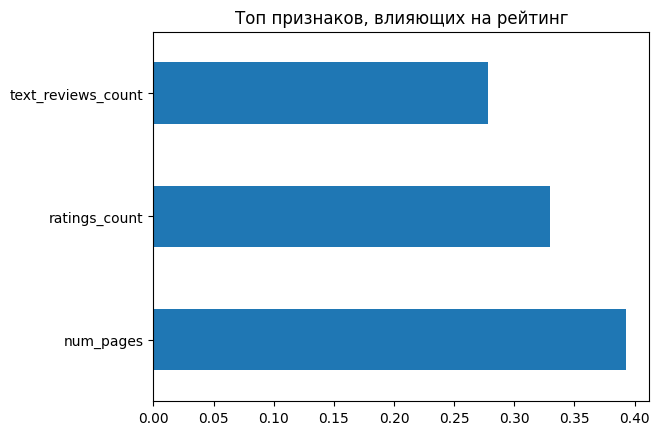

In [22]:
# 1. Инициализация модели
# n_estimators=100: Строим "парламент" из 100 деревьев
# max_depth=12: Ограничиваем глубину, чтобы деревья не зубрили шум
# n_jobs=-1: Параллелим вычисления на все ядра процессора
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=12, 
    max_features='sqrt',
    random_state=42, 
    n_jobs=-1
)

# 2. Обучение (Масштабирование для леса не требуется)
rf_model.fit(X_train, y_train)

# 3. Предсказание
y_pred_rf = rf_model.predict(X_test)

# 4. Оценка качества
print(f"Accuracy (Random Forest): {accuracy_score(y_test, y_pred_rf):.4f}")
print("\n", classification_report(y_test, y_pred_rf))

# 5. Анализ важности признаков (Feature Importance)
# Лес позволяет увидеть, какие признаки реально влияют на рейтинг
import pandas as pd
import matplotlib.pyplot as plt

feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Топ признаков, влияющих на рейтинг")
plt.show()

Здесь Accuracy еще лучше. Попробуем вместе бэггинга применить бустинг.

In [24]:
# 1. Инициализация
# learning_rate=0.1: шаг градиентного спуска. Чем меньше, тем точнее, но дольше.
# n_estimators=100: количество шагов (деревьев).
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# 2. Обучение
gb_model.fit(X_train, y_train)

# 3. Предсказание
y_pred_gb = gb_model.predict(X_test)

# 4. Оценка
print(f"Accuracy (Gradient Boosting): {accuracy_score(y_test, y_pred_gb):.4f}")
print(classification_report(y_test, y_pred_gb))

Accuracy (Gradient Boosting): 0.6008
              precision    recall  f1-score   support

           0       0.58      0.67      0.62      1516
           1       0.62      0.54      0.58      1560

    accuracy                           0.60      3076
   macro avg       0.60      0.60      0.60      3076
weighted avg       0.60      0.60      0.60      3076



Мы получили неплохой результат в 0.60, на этом здесь и остановимся.